# CNN

In this notebook, we will go through basics of CNN using MNIST dataset. We will implement this using two popular deep learning frameworks `Keras` and `PyTorch`. 

Hey yo, but what is CNN?

Well sit tight and buckle up. I will go through everything in-detail.

In [1]:
# load all the required libraries
import copy
import time
import numpy as np                                    # package for computing
from sklearn.model_selection import train_test_split  # split dataset
import torch                                          # import keras with tensorflow as backend
from torchvision import datasets                      # import mnist dataset from keras 
from torchvision import transforms            # sequential and functional api keras 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt             # matplotlib library for plotting

# display plots inline (in notebook itself)
%matplotlib inline              

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Training on %s ...'%format(device))

Training on cpu ...


In [2]:
# load mnist data

batch_size = 256
num_workers = 0
val_size = 0.2

transform = transforms.Compose([transforms.ToTensor()])

# choose the training and test datasets
train_data = datasets.MNIST('data', train=True,
                              download=True, transform=transform)
test_data = datasets.MNIST('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_test = len(test_data)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_test))
test_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(val_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

print('Training samples:', len(train_loader.dataset))
print ('Validation samples:', len(val_loader.dataset))
print('Test samples:', len(test_loader.dataset))

# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 
                    'val': val_loader}


Training samples: 60000
Validation samples: 10000
Test samples: 10000


# 

From the previous post, we learned how to split dev and test data.
Here, we keep the dimensions of the data same.




## Visualization of data

Enough talk, show me the data!

In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.squeeze(np.transpose(img, (1, 2, 0))), cmap='gray')  # convert from Tensor image

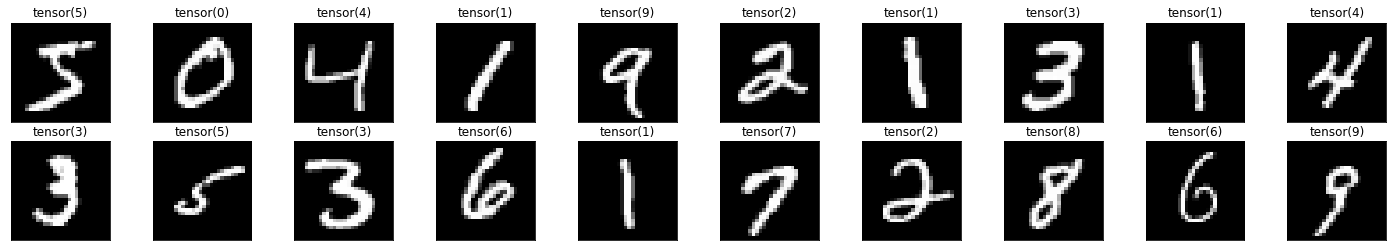

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
#display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # print out the correct label for each image
    ax.set_title(str(labels[idx]))

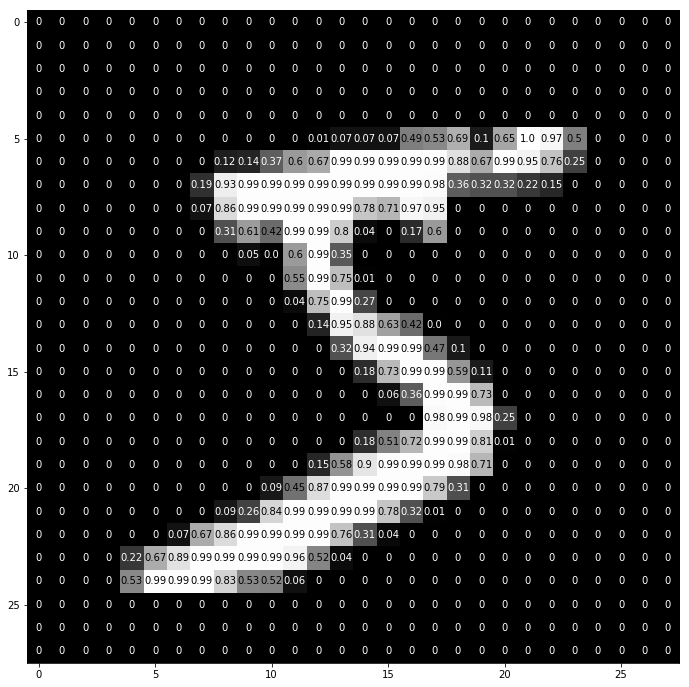

In [5]:
img = np.squeeze(images[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Overfitting and Underfitting

Suppose your training, dev and test sets all come from the same distribution. Then you should always try to get more training data, since that can only improve performance, right? 

Even though having more data can’t hurt, unfortunately it doesn’t always help.

Before understanding overfitting and underfitting, let's dive into `bias` and `variance`. There are two major sources of error in machine learning: bias and variance. Understanding them will help you decide whether adding data, as well as other tactics to improve performance, are a good use of time. 



## Cat Classifier

Back to cats, suppose we want to build a cat classifier that has 5% error rate. Training error is at 15% and dev set error is at 16%. In this case, adding more data will make training harder for algorithm to do well on training set.

If we have error rate of 15% (or 85% accuracy) on training set, but target error rate is 5% (or 95% accuracy), then the first problem to solve is to improve algorithm's performance on training set. 

Suppose as above that algorithm has 16% error (84% accuracy) on the dev set. We break the 16% error into two components:
 - First, the algorithm’s error rate on the training set. In this example, it is 15%. We think of this as the algorithm’s `bias`.
 - Second, how much worse the algorithm does on the dev (or test) set than the training set. In this example, it does 1% worse on the dev set than the training set. We think of this as the algorithm’s `variance`.
 
Training       |   Dev          | Bias(=Training error)| Variance(=Dev-Training) |  Known as        | Also Known as  |
-------------- | -------------- | --------------       | --------------          | --------------   |--------------  |
1%             |         15%    |     1%               |     14%                 | **High variance**| **Overfitting**|
15%            | 16%            |      15%             |     1%                  | **High bias**    |**Underfitting**|

We estimate the bias as 15%, and variance as 15%. This classifier has **high bias** and **high variance** : It is doing poorly on the training set, and therefore has high bias, and its performance on the dev set is even worse, so it also has high variance.

**Optimal Rate**: The “ideal” error rate—that is, one achievable by an “optimal” classifier—is nearly 0% not always.
Also known as **unavoidable bias** or **Bayes error rate**.

Suppose that we are building a speech recognition system, and find that 14% of the audio clips have so much background noise or are so unintelligible that even a human cannot recognize what was said. In this case, even the most “optimal” speech recognition system might have error around 14%.
Suppose,
 - Training error = 15% and Dev error = 30%, if optimal error = 14%

The training set performance is already close to the optimal error rate of 14%. Thus, there is not much room for improvement in terms of bias or in terms of training set performance. However, this algorithm is not generalizing well to the dev set; thus there is ample room for improvement in the errors due to variance.

- Training error = 15% and dev error = 30%, if optimal error = 0%

A training error of 15% leaves much room for improvement. This suggests bias-reducing changes might be fruitful. 
 

**Avoidable bias**: Difference between training error and optimal rate error rate. The “avoidable bias” reflects how much worse your algorithm performs on the training set than the “optimal classifier.”

**Lessons:**
  
1. dev/test set performance is usually worse than your training set performance
2. Addressing bias improves its performance on the training set
3. Addressing variance help algorithm to generalize better from the training set to dev/test set.

Too many terminologies introduced, lets walk through them

- (Training - Dev) error high ==> High variance ==> Overfitting ==> Add more data to training set
- Training error high     ==> High bias    ===> Underfitting ==> Make model more complex
- Bayes error ==> Optimal Rate  ==> Unavoidable bias
- (Training - Bayes) error ===> Avoidable bias
- Bias = Optimal error rate (“unavoidable bias”) + Avoidable bias


In next post, we will go into plotting learning curves and how to interpret them. Stay tuned!

# Introduction to CNN



CNN is convolution neural networks. 
We have seen the dataset, which consist of [0-9] numbers and images of size 28 x 28 pixels of values in range [0-1] . 


<font color='blue'> A long time ago in a galaxy far, far away.... </font>

<font color='red'>Mr.I-know-everything:</font> Hello, Young Padwan. As promised we will today look into <span class="light-pink"> Force of CNN </span>. Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous post: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still has a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) (or error function) on the last (fully-connected) layer. So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

Here, first let me tell you about convolution operation and how it works. 


So, above examples show how convolution operator works for edge detection, blurring or sharpening the image depending on different kernel values.

<font color='green'>Mr.I-know-nothing:</font> Master, How does convolution operation help us in ConvNet?

<font color='red'>Mr.I-know-everything:</font> Okay, ConvNets take advantage of the fact that input consists of images. The layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. (the word depth here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network.) For example, consider our example of MNIST where each input is of dimension 28 x 28 x 1 (width, height, depth respectively) or CIFAR-10 (another toy dataset with 10 classes of different categories), the volume has dimensions 32x32x3 (width, height, depth respectively). 


Suppose we apply filter of dimension (5x5x3) to above example of CIFAR-10 with input dimension (32x32x3) it results in output dimesion of (28x28x3) much smaller image than input. Hence, reduction in number of pixels than input.

Simpler way to calculate output dimesion O, given input dimension W and convolution filters kernel size F, padding P, and stride size S.

 O = (W + 2P - F)/S + 1
 
Now you might ask what's kernel, padding and stride in convolution filters?

Kernel(F) : The size of kernel used for convolution on input to the filter. For e.g. 5x5, 3x3 or 7x7 are popular kernel sizes. It implements element-wise computation across input matrix and outputs the sum. Kernel usually has a size that is much smaller than the original input so that we can take advantage of decrease in memory.

Consider example,


Strides(S) : When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

Consider example,


Padding(P) : Both kernel and stride function as dimension reduction technic. So for each convolution layer, the output dimension will always be smaller than input. However if we want to build a deep convolution network, we don’t want the input size to shrink too fast. A small kernel can partly solve this problem. But in order to maintain certain dimension we need zero padding. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes. Basically it is adding zero to your input.

Consider example,


So, basically a single convolution filter on input consists of these components. We can stack many such conv filters if input size is 3 dimensional.

Consider example,


Here, input -> (6x6x3), conv filter (F) -> (3x3x3), number of conv filters -> 1, padding (P) -> 0, strides (S) -> 1

Note: Always remember that depth (number of channels) of input and conv filter have to be same. 

Applying our formula for calculating output dimension: O = (6+(2*0)-3)/1 + 1 = 4

Output dimension = (4 x 4 x number of conv filters) = (4 x 4 x 1)


Consider an example of number of conv filters -> 2, all other parameters are same

Applying our formula for calculating output dimension: O = (6+(2*0)-3)/1 + 1 = 4

Output dimension = (4 x 4 x number of conv filters) = (4 x 4 x 2)


For further in-depth explaination with cool figure and [animations](https://github.com/vdumoulin/conv_arithmetic) can be found [here](https://arxiv.org/pdf/1603.07285.pdf).

Here is cool demo of how convolution filters apply to input. [Conv-demo](https://cs231n.github.io/assets/conv-demo/index.html)


So, now we have full understanding about what convolution filters are in ConvNets and different components of convolution filters.

<font color='green'>Mr.I-know-nothing:</font> Master, does ConvNet consists only of convolution filters?

<font color='red'>Mr.I-know-everything:</font> Excellent, this is where I was headed next. So, ConvNets architecture  consists of following distinct layers --> [INPUT - CONV - RELU - POOL - FC].

We have seen INPUT, CONV, RELU and FC layer in this and previous post. We will look into POOL layer.

POOLING: Pooling functions as a dimension reduction technic. It is also referred to as a downsampling layer. But unlike kernel which reduces all dimensions, pooling keep channel dimension untouched. This reduces the size of the feature maps thus reducing the number of nodes in the future layers which improve efficiency of the model. Basically Pooling outputs a certain statistics for a certain among of input. This introduces a feature stronger than Equivariant representation — Invariant representation. In short, it is used to detect the object regardless of where the object is placed. For e.g., we want our network to output label 2, even if input example of 2 is in far right corner or bottom left corner. There are many types of pooling layer, Max-pooling, Average-pooling, GlobalMaxPooling, GlobalAveragePooling.

Consider example,


Now, you have full understanding of different layers used in ConvNet and their different components.

<font color='green'>Mr.I-know-nothing:</font> Master, ConvNets consists of applying [CONV - RELU - POOL] operation repeatedly, when are using FC layer?

<font color='red'>Mr.I-know-everything:</font> Absolutely, the most common ConvNet architecture follows the pattern:
 INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC, where the * indicates repetition, and the POOL? indicates an optional pooling layer.

Deep ConvNet consists of repetition of [CONV - RELU - POOL] layers and once sufficient depth is introduced, then we flatten the output of above and connect it with fully connected layer.

Consider example, 


<font color='green'>Mr.I-know-nothing:</font> Now I understand what is happening in convolution layers and how a typical ConvNet architecture is. How does training ConvNets work? Does it still consist of forward pass and backward pass? What is the loss function or error function? Does it still use `jar jar backpropogation` for passing error? 

<font color='red'>Mr.I-know-everything:</font> Those are some excellent question. So, now having explained what ConvNet architectures are we have a model just like one in MLP, we input image to that model, and the model outputs the class the input image belongs to. Training ConvNets is similar, we have a loss function just like in MLP, we use softmax layer to output the probabilities of input belonging to particular class. We do a forward propogation of passing input to ConvNets to calculate the error between output $$\mathbf{y}$$ and target  $$\mathbf{\hat_{y}}$$ and backpropogate the error from FC - POOL - RELU - CONV - INPUT. 

Note: To see, how `jar jar backpropogation` works in ConvNets, have a look [here](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/).

This is how a typical training ConvNets looks like.

Now digress a bit and take you back to story of where convnets got their insipiration from. The work by Hubel and Wiesel in 1950s and 1960s showed that cat(yup, cats and cats everywhere) and monkey visual cortexes contain neurons that individually respond to small regions of the visual field. Provided the eyes are not moving, the region of visual space within which visual stimuli affect the firing of a single neuron is known as its receptive field. 

In 1957, Mark I Perceptron by Frank Rosenblatt was the first implementation of the perceptron algorithm. Back then, Frank Rosenblatt used step function as activation function and as we know that step function is non-differentiable, the alogrithm did not learn effectively. There was no concept of backpropogation back then. In 1960s, Widrow and Hoff stacked these perceptrons into multi-layer network still no backpropogation. In 1980, Fukushima proposed neocognitron, a hierarchical, multilayered artificial neural network which was used for handwritten character recognition and other pattern recognition tasks, and served as the inspiration for convolutional neural networks. Next boost came in around 1986, there was this influential paper that basically is the first time we see backpropogation like rules in seminal paper by Rumelhart, Hinton and Williams, when they were playing with mulit-layer perceptron. The only problem was the deep layer network were not very scalable, training would get stuck and backprop was not working well for these very deep networks.

In the year 1994, one of the very first convolutional neural networks, and what propelled the field of Deep Learning. This pioneering work by Master Yann LeCun was named LeNet5 after many previous successful iterations since they year 1988. In the years from 1998 to 2010 neural network were in incubation. Most people did not notice their increasing power, while many other researchers slowly progressed. In 2010 Dan Claudiu Ciresan and Jurgen Schmidhuber published one of the very fist implementations of [GPU Neural nets](https://arxiv.org/abs/1003.0358). This implementation had both forward and backward implemented on a a NVIDIA GTX 280 graphic processor of an up to 9 layers neural network.

In 2006, again Hinton's [paper](http://www.cs.toronto.edu/~hinton/absps/cbpweb.pdf), reinvigorated research in deep learning and used Restricted Boltzmann machines(RBM) and showed how model trained using backpropogation from scratch. In 2010s [paper](http://www.cs.toronto.edu/~gdahl/papers/DRAFT_DBN4LVCSR-TransASLP.pdf), there were really big results were neural network really worked very well than Kernels, SVMs and so on. specifically in the area of speech recognition, the neural network gave them huge improvement when swapped with HMM (Hidden Markov Models) and GMMs (Gaussian Mixture Models). This was the first time neural networks gave a large improvement indicating that neural networks work.

In 2012, [seminal paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) by Alex Krizhevsky and Ilya Sutskever with Geoffrey Hinton (again) proposed AlexNet architecture which was used to classify 1000 categories and 1.2 million images in a competition organized by Stanford AI group, called [seminal competition](http://www.image-net.org/)ImageNet with efforts from Fe-Fe-Li, many graduate students and Mechanical Turk. AlexNet contained eight layers; the first five were convolutional layers, some of them followed by max-pooling layers, and the last three were fully connected layers. It used the non-saturating ReLU activation function, which showed improved training performance over tanh and sigmoid. The network achieved a top-5 error of 15.3%, more than 10.8% points lower than that of the runner up. In 2012, AlexNet significantly outperformed all the prior competitors and won the challenge by reducing the top-5 error from 26% to 15.3%.  Suddenly people started to pay attention, not just within the AI community but across the technology industry as a whole. This result change course of community, and this competition and result sky-rocketed in very cool architectures eventually surpassing human performance at classifying 1.2 million images into 1000 categories.

Read more about both paper and competition: [here](https://qz.com/1307091/the-inside-story-of-how-ai-got-good-enough-to-dominate-silicon-valley/) and [here](https://qz.com/1034972/the-data-that-changed-the-direction-of-ai-research-and-possibly-the-world/).


Here is the image showing the error rate from year 2012 to 2018.



We will discuss some of the state of the art architectures.

1. LeNet 

LeNet-5, a pioneering 7-level convolutional network by LeCun et al in 1998. Of these, the best known is the LeNet architecture that was used to read zip codes, digits, etc.

Image

2. AlexNet

AlexNet contained eight layers; the first five were convolutional layers, some of them followed by max-pooling layers, and the last three were fully connected layers. It used the non-saturating ReLU activation function, which showed improved training performance over tanh and sigmoid. AlexNet was trained for 6 days simultaneously on two Nvidia Geforce GTX 580 GPUs which is the reason for why their network is split into two pipelines.

Image


3. ZFNet

It achieved a top-5 error rate of 14.8% which is now already half of the prior mentioned non-neural error rate. It was mostly an achievement by tweaking the hyper-parameters of AlexNet while maintaining the same structure. The ILSVRC 2013 winner was a Convolutional Network from Matthew Zeiler and Rob Fergus. 

Image


4. VGG

VGGNet by Oxford's renowned Visual Geometry Group consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters. Trained on 4 GPUs for 2–3 weeks. It is currently the most preferred choice in the community for extracting features from images.

Image

5. GoogLeNet (Inception v1)

The network used a CNN inspired by LeNet but implemented a novel element which is dubbed an inception module. It used batch normalization, image distortions and RMSprop. This module is based on several very small convolutions in order to drastically reduce the number of parameters. Their architecture consisted of a 22 layer deep CNN but reduced the number of parameters from 60 million (AlexNet) to 4 million. It achieved a top-5 error rate of 6.67%. The winner of the ILSVRC 2014 competition was GoogleNet(a.k.a. Inception V1) from Google.

Image

6. ResNet

At the ILSVRC 2015, the so-called Residual Neural Network (ResNet) by Kaiming He et al at Microsoft Asia Research Group introduced a novel architecture with “skip connections” and features heavy batch normalization. Such skip connections are also known as gated units or gated recurrent units and have a strong similarity to recent successful elements applied in RNNs. Thanks to this technique they were able to train a NN with 152 layers while still having lower complexity than VGGNet. It achieves a top-5 error rate of 3.57% which beats human-level performance.

Image



Oh, and one last thing about how to find parameters of the model?

- Each Layer may or may not have parameters 
 - CONV/FC do 
 - RELU/POOL/DROPOUT don’t
- Each Layer may or may not have additional hyperparameters 
 - CONV/FC/POOL/DROPOUT do
 - RELU doesn’t

Consider an example of model which we will implement below:

Layers                             |    Input Shape     |   Output Shape   |   Memory         |    Weights            |    
--------------                     |  --------------    |  --------------  | --------------   | --------------        |
INPUT                              |      (28 x 28 x 1) |   (28 x 28 x 1)  |    28 * 28 * 1 = 784   |       0               |
CONV(3x3, 32, stride=1, padding=0) |      (28 x 28 x 1) |   (26 x 26 x 32) | 26 * 26 * 32 = 21632   |(3 * 3 * 1) * 32 = 288 |
CONV(3x3, 64, stride=1, padding=0) |      (26 x 26 x 32)|   (24 x 24 x 64) |24 * 24* 64 = 36864   |(3 * 3 * 32) * 64 = 18342     | 
POOL(2x2)                          |      (24 x 24 x 64)|   (12 x 12 x 64) | 12 *12 * 64 = 9216    |    0                  |
DROPOUT()                          |      (12 x 12 x 64)|   (12 x 12 x 64) | 12 * 12 * 64 = 9216    |    0                  |
FLATTEN()                          |      (12 x 12 x 64)|   (9216)         |    9216          |    0                  |
DENSE(128)                         |      (9216)        |   (128)          |    128           | 9216 * 128 = 1179648     |
DROPOUT()                          |      (128)         |   (128)          |    128           |    0                  |
DENSE(num_classes=10)              |      (128)         |   (10)           |    10            |    128 * 10 = 1280        |
       --                          |           --       |          Total   |    87194         | 11999558              |    

Total Memory ~= 87K * 4 bytes ~= 0.3MB / image (only forward ~ *2 backward pass)  

Total Parameters = 11999558 ~= 1.2M parameters (without biases)


Put this in footnotes
A  Comprehensive Survey on Deep Learning Approaches  (https://arxiv.org/pdf/1803.01164.pdf)



## Sequential API

In [6]:
# [0-9] unique labels
num_classes = 10
epochs = 5

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        D_in = 784
        H = 16
        D_out = num_classes
        self.classifier = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.25),
            Flatten(),
            nn.Linear(12*12*64, 128),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        
        # 2 conv layer, with relu activation function
        x = self.classifier(x)
        return x

# initialize the NN
model = Net()
model = model.to(device)
print(model)

Net(
  (classifier): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25)
    (6): Flatten()
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): Dropout(p=0.5)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): LogSoftmax()
  )
)


In [8]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print (len(dataloaders[phase].dataset))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, epochs)

Epoch 0/4
----------
train Loss: 0.2784 Acc: 0.9134
60000
val Loss: 0.0574 Acc: 0.9585
10000
Epoch 1/4
----------
train Loss: 0.0819 Acc: 0.9728
60000
val Loss: 0.0433 Acc: 0.9604
10000
Epoch 2/4
----------
train Loss: 0.0632 Acc: 0.9780
60000
val Loss: 0.0339 Acc: 0.9634
10000
Epoch 3/4
----------
train Loss: 0.0503 Acc: 0.9820
60000
val Loss: 0.0359 Acc: 0.9624
10000
Epoch 4/4
----------
train Loss: 0.0432 Acc: 0.9845
60000
val Loss: 0.0345 Acc: 0.9619
10000
Training complete in 25m 44s
Best val Acc: 0.963379


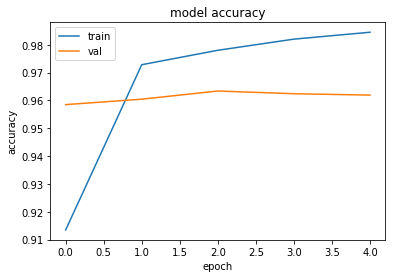

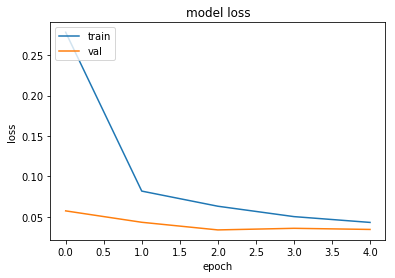

In [11]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.033183

Test Accuracy of     0: 99% (787/790)
Test Accuracy of     1: 99% (921/926)
Test Accuracy of     2: 99% (803/808)
Test Accuracy of     3: 98% (808/820)
Test Accuracy of     4: 99% (767/774)
Test Accuracy of     5: 98% (706/714)
Test Accuracy of     6: 98% (744/754)
Test Accuracy of     7: 97% (797/816)
Test Accuracy of     8: 98% (772/784)
Test Accuracy of     9: 97% (793/814)

Test Accuracy (Overall): 98% (7898/8000)


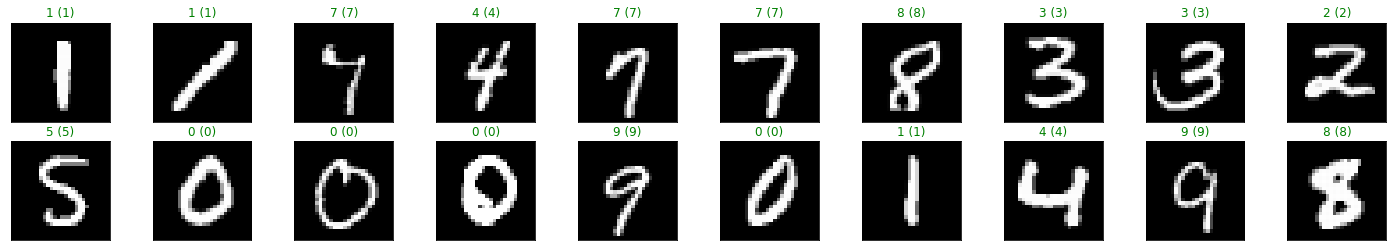

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Functional API

In [14]:
# [0-9] unique labels
num_classes = 10
epochs = 5

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.output(x), dim=1)
        return x

# create a complete CNN
model = Net()
model = model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print (len(dataloaders[phase].dataset))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [22]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, epochs)

Epoch 0/4
----------
train Loss: 0.3591 Acc: 0.8874
60000
val Loss: 0.0627 Acc: 0.9570
10000
Epoch 1/4
----------
train Loss: 0.1097 Acc: 0.9648
60000
val Loss: 0.0405 Acc: 0.9653
10000
Epoch 2/4
----------
train Loss: 0.0784 Acc: 0.9739
60000
val Loss: 0.0335 Acc: 0.9678
10000
Epoch 3/4
----------
train Loss: 0.0649 Acc: 0.9777
60000
val Loss: 0.0272 Acc: 0.9692
10000
Epoch 4/4
----------
train Loss: 0.0551 Acc: 0.9801
60000
val Loss: 0.0306 Acc: 0.9678
10000
Training complete in 25m 56s
Best val Acc: 0.969238


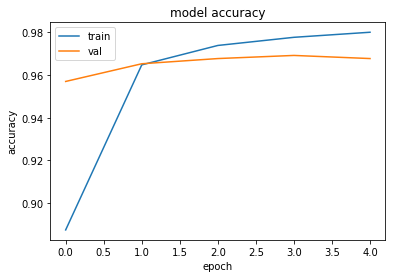

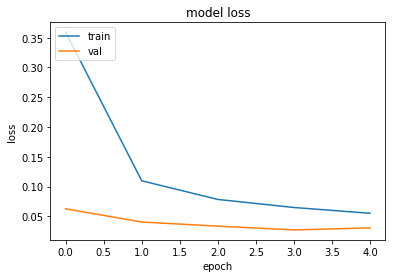

In [23]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.028171

Test Accuracy of     0: 99% (788/790)
Test Accuracy of     1: 99% (923/926)
Test Accuracy of     2: 99% (802/808)
Test Accuracy of     3: 98% (805/820)
Test Accuracy of     4: 99% (769/774)
Test Accuracy of     5: 99% (709/714)
Test Accuracy of     6: 98% (742/754)
Test Accuracy of     7: 98% (804/816)
Test Accuracy of     8: 98% (772/784)
Test Accuracy of     9: 97% (790/814)

Test Accuracy (Overall): 98% (7904/8000)


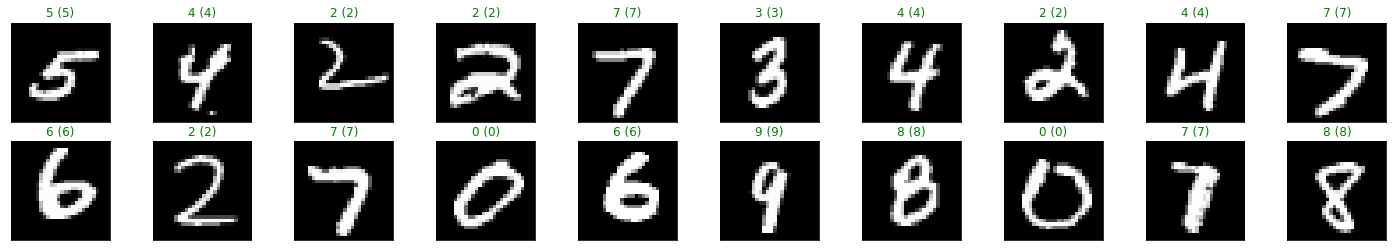

In [25]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

<font color='red'>Mr.I-know-everything:</font> Young Padwan, now you have the same power as me to train an CNN. Now knock yourself and experiement with different number of layers. Also, try to experiement with different architectures and observe the overfitting and underfitting. In next post, we will go over the `Power of Transfer Learning`. Master Karpathy says, "If you’re feeling a bit of a fatigue in thinking about the architectural decisions, you’ll be pleased to know that in 90% or more of applications you should not have to worry about these. I like to summarize this point as “don’t be a hero”: Instead of rolling your own architecture for a problem, you should look at whatever architecture currently works best on ImageNet, download a pretrained model and finetune it on your data. You should rarely ever have to train a ConvNet from scratch or design one from scratch." So, we don't need be on Googleino to train powerful CNNs, we can do it on our planet too!

<font color='green'>Mr.I-know-nothing:</font> Thank you Master.

Happy Learning!